In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from pmdarima import auto_arima
import warnings


In [114]:
tickerSymbol = 'AAPl'   #EMG.L
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(interval='1d',start='2017-4-1',end='2022-6-1',)
tickerDf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-04-03 00:00:00-04:00,33.768545,33.864883,33.613460,33.766193,79942800,0.0,0.0
2017-04-04 00:00:00-04:00,33.660447,34.045809,33.641648,34.017612,79565600,0.0,0.0
2017-04-05 00:00:00-04:00,33.888376,34.179748,33.792034,33.841381,110871600,0.0,0.0
2017-04-06 00:00:00-04:00,33.904831,33.958878,33.707451,33.756798,84596000,0.0,0.0
2017-04-07 00:00:00-04:00,33.773243,33.878982,33.665156,33.681602,66688800,0.0,0.0
...,...,...,...,...,...,...,...
2022-05-24 00:00:00-04:00,140.381810,141.538287,136.912397,139.933182,104132700,0.0,0.0
2022-05-25 00:00:00-04:00,138.009041,141.358824,137.919318,140.092697,92482700,0.0,0.0
2022-05-26 00:00:00-04:00,136.972206,143.901068,136.722966,143.342773,90601500,0.0,0.0


In [115]:
tickerDfResample = pd.DataFrame(tickerDf.resample('1d').sum())
tickerDfResample[tickerDfResample == 0] = None
tickerDfResample = tickerDfResample.interpolate(method='pad')
tickerDfResample = np.log(tickerDfResample)
tickerDfResample

first_diff = tickerDfResample.Close.values[1:]-tickerDfResample.Close.values[:-1]
first_diff = np.concatenate([first_diff,[0]])
tickerDfResample['FirstDifference'] = first_diff
tickerDfResample['PercentageChange'] = tickerDfResample.Close.pct_change().fillna(0) #  "by what percentage did previous value change to get to current value"current value - previous value / previous value = pct change
tickerDfResample

,Open,High,Low,Close,Volume,Dividends,Stock Splits,FirstDifference,PercentageChange
Date,,,,,,,,,
2017-04-03 00:00:00-04:00,3.519530,3.522379,3.514927,3.519460,18.196822,NaN,NaN,0.007418,0.000000
2017-04-04 00:00:00-04:00,3.516323,3.527707,3.515765,3.526878,18.192092,NaN,NaN,-0.005194,0.002108
2017-04-05 00:00:00-04:00,3.523072,3.531633,3.520225,3.521684,18.523883,NaN,NaN,-0.002503,-0.001473
2017-04-06 00:00:00-04:00,3.523558,3.525150,3.517719,3.519182,18.253398,NaN,NaN,-0.002230,-0.000711
2017-04-07 00:00:00-04:00,3.519669,3.522795,3.516463,3.516952,18.015548,NaN,NaN,0.000000,-0.000634
...,...,...,...,...,...,...,...,...,...
2022-05-27 00:00:00-04:00,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.008046
2022-05-28 00:00:00-04:00,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000
2022-05-29 00:00:00-04:00,4.976374,5.005454,4.975480,5.005187,18.326134,-1.469676,1.386294,0.000000,0.000000


In [116]:
tickerDfResample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1885 entries, 2017-04-03 00:00:00-04:00 to 2022-05-31 00:00:00-04:00
Freq: D
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1885 non-null   float64
 1   High              1885 non-null   float64
 2   Low               1885 non-null   float64
 3   Close             1885 non-null   float64
 4   Volume            1885 non-null   float64
 5   Dividends         1847 non-null   float64
 6   Stock Splits      639 non-null    float64
 7   FirstDifference   1885 non-null   float64
 8   PercentageChange  1885 non-null   float64
dtypes: float64(9)
memory usage: 147.3 KB


In [117]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. ADF: ",dftest[0])
    print("2. P_value: ",dftest[1])
    print("3. num_lags: ",dftest[2])
    print("4. : ",dftest[3])
    print("5. crit_value: ",dftest[4])
    for key,val in dftest[4].items():
        print("\t",key,": ",val)
        
ad_test(tickerDfResample['Close'])

1. ADF:  -0.6590415964952532
2. P_value:  0.8570754277924466
3. num_lags:  13
4. :  1871
5. crit_value:  {'1%': -3.433849890092939, '5%': -2.863086004488984, '10%': -2.567593036523882}
	 1% :  -3.433849890092939
	 5% :  -2.863086004488984
	 10% :  -2.567593036523882


In [119]:
warnings.filterwarnings("ignore")
stepwise_fit = auto_arima(tickerDfResample['Close'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10141.491, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10126.275, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10146.911, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10147.333, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10123.981, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10145.318, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10145.327, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10143.356, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-10143.854, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.233 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1885
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5076.666
Date:                Tue, 24 Jan 2023   AIC                         -10147.333
Time:                        19:31:18   BIC                         -10130.709
Sample:                    04-03-2017   HQIC                        -10141.210
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      2.288      0.022       0.000       0.001
ma.L1         -0.1110      0.015     -7.294      0.000      -0.141      -0.081
sigma2         0.0003    3.7e-06     72.150      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7190.52
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

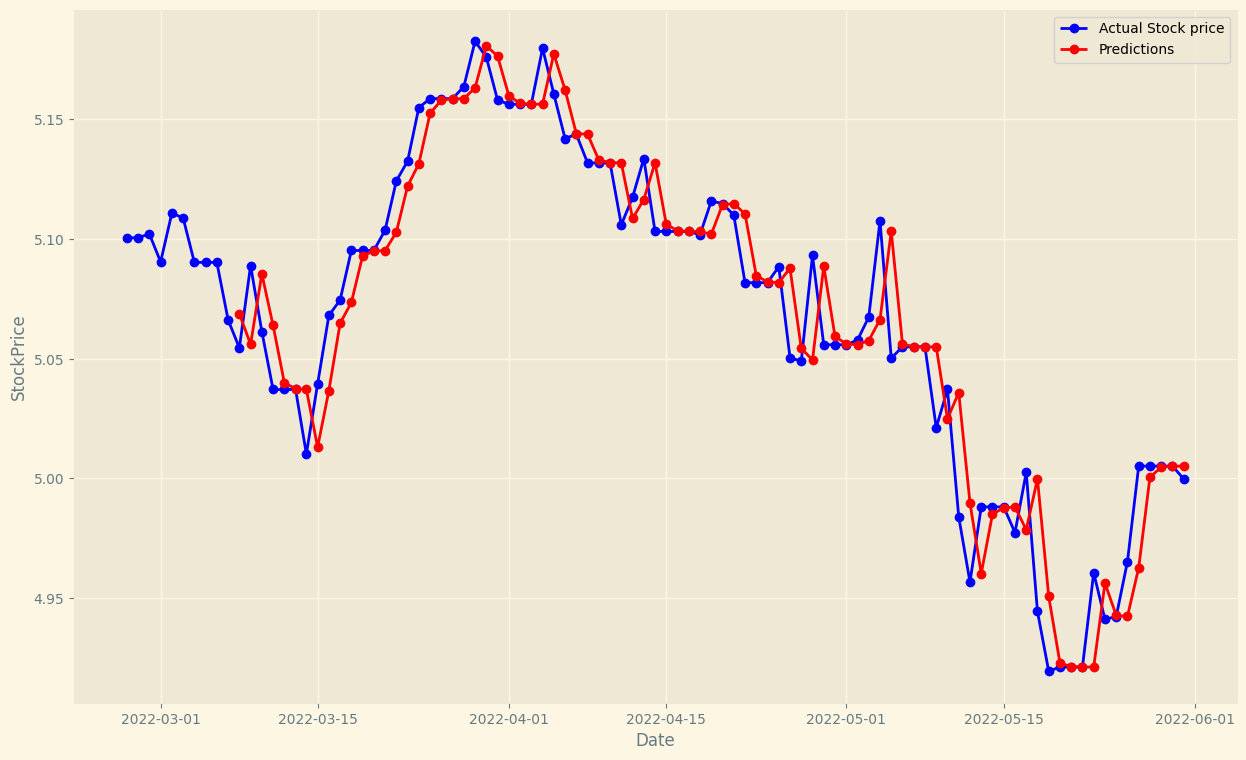

In [105]:
#close price prediction
trainData = tickerDfResample['Close'][0:1800]
testData = pd.DataFrame(tickerDfResample['Close'][1800:])
testData['Predictions'] = 0 
for i in range(len(testData)):
    model = ARIMA(trainData,order=(0,1,1))
    modelFit = model.fit()
   
    futureForcast = modelFit.forecast(20)
    futureForcast = np.mean(futureForcast)
    testData['Predictions'][i]=futureForcast
    
    trainData = trainData.append(testData['Close'][i:i+1])
    trainData = trainData[1:]
    
   
    
    
#plot for close price prediction
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,9))


plt.plot(tickerDfResample['Close'][1790:],'-bo',label='Actual Stock price')
plt.plot(testData['Predictions'],'-ro',label='Predictions')
plt.legend()
plt.xlabel("Date")
plt.ylabel("StockPrice")
plt.show() 

In [120]:
#Fbprophet prediction
df = pd.DataFrame(tickerDfResample['Close'][0:1250]).reset_index()
df.columns = ['ds','y']
df['ds'] = df['ds'].dt.tz_localize(None)
testData = pd.DataFrame(tickerDfResample['Close'][1250:])

model = Prophet()
model.fit(df)

19:31:36 - cmdstanpy - INFO - Chain [1] start processing
19:31:36 - cmdstanpy - INFO - Chain [1] done processing


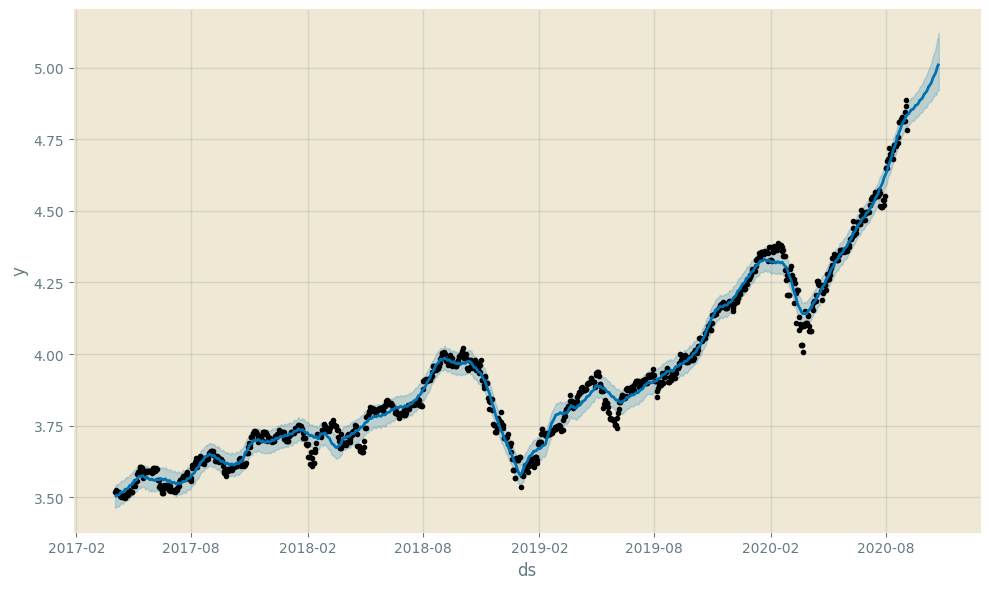

In [121]:
futureDates = model.make_future_dataframe(periods = 50)
prediction = model.predict(futureDates)
fig = model.plot(prediction)